In [1]:
import os

import clean
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers

In [5]:
pl.scan_parquet(clean.data_dir("samples/simple_joined.pq")).with_row_index().group_by(
    pl.col("sensor_voltage").round()
).agg(pl.col("index").count()).sort("sensor_voltage").with_columns(
    cum_total=pl.col("index").cum_sum(reverse=True)
).drop("index").collect()[137:143]

sensor_voltage,cum_total
f64,u32
133.0,745
134.0,703
137.0,658
142.0,535
148.0,525
153.0,440


In [6]:
resampled: pl.DataFrame = (
    pl.read_parquet(clean.data_dir("samples/simple_joined.pq"))
    .sample(fraction=1, shuffle=True, seed=1)
    .lazy()
    .with_columns(grp=pl.col("sensor_voltage").cut([30, 100, 140]))
    .with_row_index()
    .with_columns(grp_id=pl.col("index").rle_id().over("grp"))
    .filter(pl.col("grp_id").lt(535))
    .drop("grp", "index", "grp_id")
    .collect()
)

In [7]:
resampled.sample(fraction=1, shuffle=True, seed=1).write_parquet(
    clean.data_dir("samples/simple_resampled.pq")
)
clean.split_data("simple_resampled.pq")
resampled.lazy().select(
    pl.col("sensor_voltage").cut([30, 100, 140]).value_counts()
).unnest("sensor_voltage").collect()

sensor_voltage,count
cat,u32
"""(-inf, 30]""",535
"""(30, 100]""",535
"""(100, 140]""",535
"""(140, inf]""",535


In [9]:
splits = np.load(clean.data_dir("samples/simple_resampled_splits.npz"))
i_train, i_tune, i_test, t_train, t_tune, t_test = (
    splits[part]
    for part in ["i_train", "i_tune", "i_test", "t_train", "t_tune", "t_test"]
)

In [24]:
keras.utils.set_random_seed(42)

input_norm = layers.Normalization(
    axis=-1, mean=i_train.mean(axis=0), variance=i_train.var(axis=0)
)
output_denorm = layers.Normalization(
    axis=-1,
    invert=True,
    mean=t_train.mean(axis=0),
    variance=t_train.var(axis=0),
)

model = keras.Sequential(
    [
        layers.Input((4,), batch_size=50),
        input_norm,
        layers.Dense(40, activation="relu", name="layer1"),
        layers.Dense(100, activation="relu", name="layer2"),
        layers.Dense(10, activation="relu", name="layer3"),
        layers.Dense(1, name="out"),
        output_denorm,
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.losses.MeanAbsolutePercentageError()],
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (50, 4)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (50, 40)               │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (50, 100)              │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (50, 10)               │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (50, 1)                │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_7 (Normalization) │ (50, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321 (20.79 KB)

 Trainable params: 5,321 (20.79 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
keras.utils.set_random_seed(42)

history = model.fit(
    i_train,
    t_train,
    batch_size=500,
    epochs=30,
    validation_data=(i_tune, t_tune),
    # callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True)],
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - loss: 3467.8474 - mean_absolute_percentage_error: 1251.2092 - val_loss: 3435.1277 - val_mean_absolute_percentage_error: 948.1033
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3335.5005 - mean_absolute_percentage_error: 1229.2664 - val_loss: 3422.6643 - val_mean_absolute_percentage_error: 954.5095
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3247.8162 - mean_absolute_percentage_error: 1227.8274 - val_loss: 3461.8293 - val_mean_absolute_percentage_error: 950.7597
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3280.4351 - mean_absolute_percentage_error: 1307.5574 - val_loss: 3396.0715 - val_mean_absolute_percentage_error: 939.8527
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3193.9873 - mean_absolute_percentage_error: 1201.4856 - val_loss: 3351.2480 - val_mean_absolute_percentage_error: 930.9653
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3157.4685 - mean_absolute_percentage_error: 122

In [5]:
model.save("../models/poc.keras")

In [6]:
model = keras.models.load_model("../models/poc.keras")

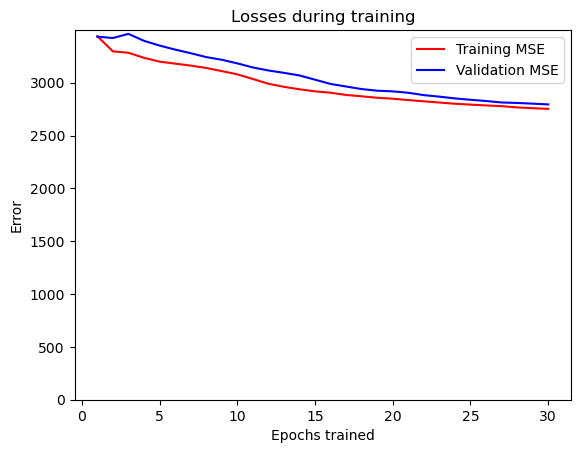

In [26]:
x = range(1, 31)

plt.plot(x, history.history["loss"], color="red", label="Training MSE")

plt.plot(x, history.history["val_loss"], color="blue", label="Validation MSE")
plt.legend()
plt.title("Losses during training")
plt.xlabel("Epochs trained")
plt.ylabel("Error")
plt.ylim((0, None))
plt.show()

In [8]:
# keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [27]:
(
    pl.DataFrame(
        {"Predicted": np.array(model(i_test).flatten()), "Actual (resampled)": t_test}
    )
    .lazy()
    .melt(value_name="Voltage", variable_name="Distribution")
    .with_row_index()
    .group_by("Distribution", pl.col("Voltage").round())
    .agg(Frequency=pl.col("index").count())
    .sort("Voltage")
    .collect()
    .plot.line(
        x="Voltage",
        y="Frequency",
        by="Distribution",
        title="Resampled distribution results",
    )
)

:NdOverlay   [Distribution]
   :Curve   [Voltage]   (Frequency)

In [28]:
results = model.evaluate(i_test, t_test, batch_size=5000)

print("RMSE:", np.sqrt(results[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2520.0308 - mean_absolute_percentage_error: 1060.3817
RMSE: 50.199907985162184
